In [1]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import math
import mplstereonet

#load SNE
sys.path.append("../../")
from pycompass.IOTools import ccXML
from pycompass.SNE import pdf


%matplotlib inline

In [2]:
"""
Extracts traces from a subset of the dataset and build snes
"""
def getTraces( dataset, subset, min_size = 50 ):
    trace_data = []
    for d in subset:
        #get dyke regions
        name, upper, interior, lower = data.extractRegions(data = d)

        #extract traces
        for i,obj in enumerate(name): 
            upper_traces = []
            lower_traces = []
            if upper[i] != None:
                trace_upper = data.extractTraces(data=upper[i], strict=False)
                for t in trace_upper:
                    #sne = SNE.SNE(t,minP=min_size)
                    upper_traces.append(t)
            if lower[i] != None:
                trace_lower = data.extractTraces(data=lower[i], strict=False)
                for t in trace_lower:
                    #sne = SNE.SNE(t,minP=min_size)
                    lower_traces.append(t)
            #build and store data array
            trace_data.append([upper_traces,lower_traces])
    return trace_data

In [3]:
os.chdir(r'G:\My Drive\Documents\PhD\Analysis\Build Stereonets\data')
data = ccXML("hoyo_verde_cliff.xml")

dykes = getTraces(data,data.filterByName("Intrusions*"))
bedding = getTraces(data,data.filterByName("Bedding*"))

Warning - could not find point data for trace 3258570


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


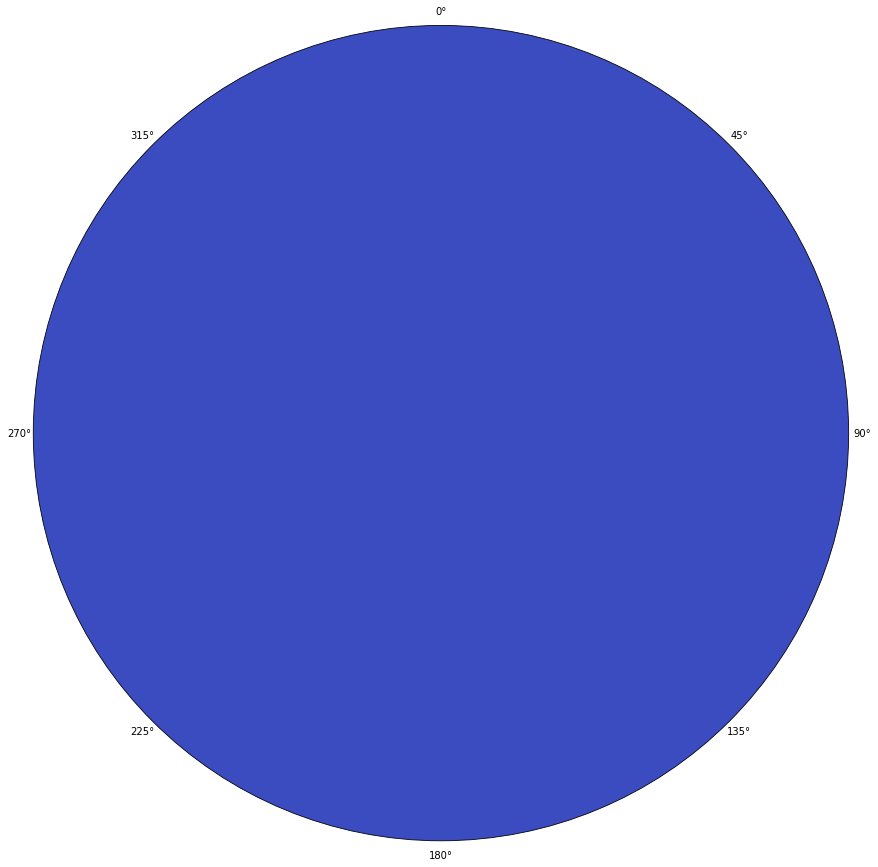

In [4]:
def fitPlaneToTrace(trace,ax):
    icov = np.linalg.inv(np.cov(trace[0:3]))
    normal = np.array([np.mean(trace[3]),np.mean(trace[4]),np.mean(trace[5])])
    
    #calculate best-fit plane
    eval,evec = np.linalg.eig(icov)
    idx = eval.argsort()[::-1] #sort eigens in decending order...
    eval = eval[idx]
    evec = evec[:,idx] #n.b. columns of evec are vectors....

    arcNormal = evec[:,2]
    bestPole = evec[:,0]
    
    #grid arc
    arc = pdf.gridArc(icov,200)
    
    #evaluate posterior
    post = pdf.posteriorExp1D(arc,icov,trace.shape[1],normal,steps=500) #icov.shape[1]
    
    #remove low parts of posterior
    post = post[np.where(post > 0.01)]
    px = arc[1][np.where(post > 0.01)]
    py = arc[0][np.where(post > 0.01)]
    
    #compute colors
    ax.scatter(px,py,c=post,s=10,cmap="coolwarm")

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='stereonet')
ax.set_facecolor(plt.get_cmap("coolwarm")(0))
for upper,lower in dykes:
    if len(upper) != 0:
        #loop through traces
        for t in upper:
            fitPlaneToTrace(t,ax)
            
    if len(lower) != 0:
        for t in lower:
            fitPlaneToTrace(t,ax)
plt.show()

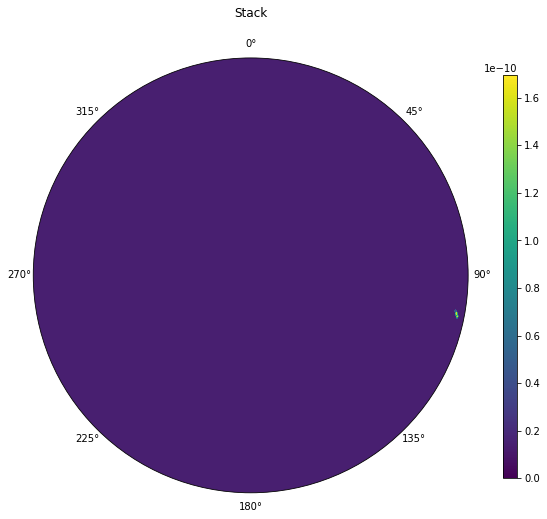

In [7]:
def crunch(trace,grid):
    cov = np.cov(trace[0:3])
    normal = np.array([np.mean(trace[3]),np.mean(trace[4]),np.mean(trace[5])])
    
    #evaluate posterior
    return pdf.posteriorExp1D(grid,cov,trace.shape[1],normal,steps=500)

#utitlity function for plotting grids
def plotGrids(titles, grid, values):
    """
    Plots a list of values on a gridded stereonets. The grid is 
    is expected to be a complete hemisphere in lat/long coordinates.
    """
        
    nAxes = len(values) #number of axes to draw
    bound = np.pi / 2 #boundaries of the stereonet hemisphere
    minV = 99999999999999999 #min for color ramp
    maxV = -9999999999999999 #max for color ramp
    
    patches = [] #list of patch objects for each grid
    for i in range(len(values)):
        
        #build patches for this grid
        patches.append([])
        
        #loop through points in grid and create patch objects
        for _lat,_lon in grid.T:
            patches[i].append(mpl.patches.Circle( (_lon, _lat), .02)) #store "dot" for plotting
        
        #check minV and maxV
        if np.min(values[i]) < minV:
            minV = np.min(values[i])
        if np.max(values[i]) > maxV:
            maxV = np.max(values[i])
    
    #init figure
    fig = plt.figure(figsize=(8 * nAxes, 8))
    
    #build throw-away axes to get color-ramp object
    cmap_name = "viridis" #plasma
    ax = fig.add_subplot(111, projection='stereonet')
    x = np.linspace(minV,maxV)
    y = np.linspace(minV,maxV)
    CS3 = ax.scatter(x,y,c=x, cmap=cmap_name)
    fig.clf()
    
    #create normalization object for color-mapping
    #now create colour map
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=minV,vmax=maxV) 

    #build axes
    for i in range(nAxes):
        pos = "1%d%d" % (nAxes,i+1)
        ax = fig.add_subplot(pos, projection='stereonet')
        ax.set_title(titles[i],y=1.08)
        
        #reshape grid for matplotlib contourf
        res = int(np.sqrt(len(values[i])))
        assert res**2 == len(values[i]), "Error: values must be sampled from a square grid."
        vals = np.reshape(values[i],(res,res)).T
        
        
        #push contour points
        bound = np.pi / 2
        ax.contourf(np.linspace(-bound,bound,res),np.linspace(-bound,bound,res), vals)
        
        #ax.set_facecolor(cmap(0)) #set background color
        
        #calculate patch colors
        #rgba = cmap( norm( values[i] ) )  
        
        #gather and plot patches
        #collection = mpl.collections.PatchCollection(patches[i])
        #collection.set_facecolor(rgba)
        #collection.set_edgecolor(rgba)
        #ax.add_collection(collection)
        #ax.grid(color='w', linestyle='--', linewidth=0.75)
        
    #finally, add the color-ramp
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    fig.colorbar(CS3, cax=cbar_ax)
    
    return fig

grid = pdf.grid(250)
out = np.zeros([250*250])
for upper,lower in dykes[1:2]: #don't do all dykes otherwise computer will run all night
    if len(upper) != 0:
        #loop through traces
        for t in upper:
            out += crunch(t,grid)
    if len(lower) != 0:
        for t in lower:
            out += crunch(t,grid)

stereonet = plotGrids(["Stack"],grid,[np.log(out+1e-50)]) #plot results